In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.datasets import DatasetFolder

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

In [3]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
    #  transforms.RandomErasing(0.4),
    #  transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [4]:
trainset = ImageFolder("train/", transform=transform)

# Określenie proporcji podziału (np. 80% danych treningowych, 20% danych testowych)
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

# Podział trainset na zbiory treningowy i testowy
train_dataset, test_dataset = random_split(trainset, [train_size, test_size])

# Utworzenie DataLoader dla każdego zbioru danych
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=16)


classes = trainset.classes

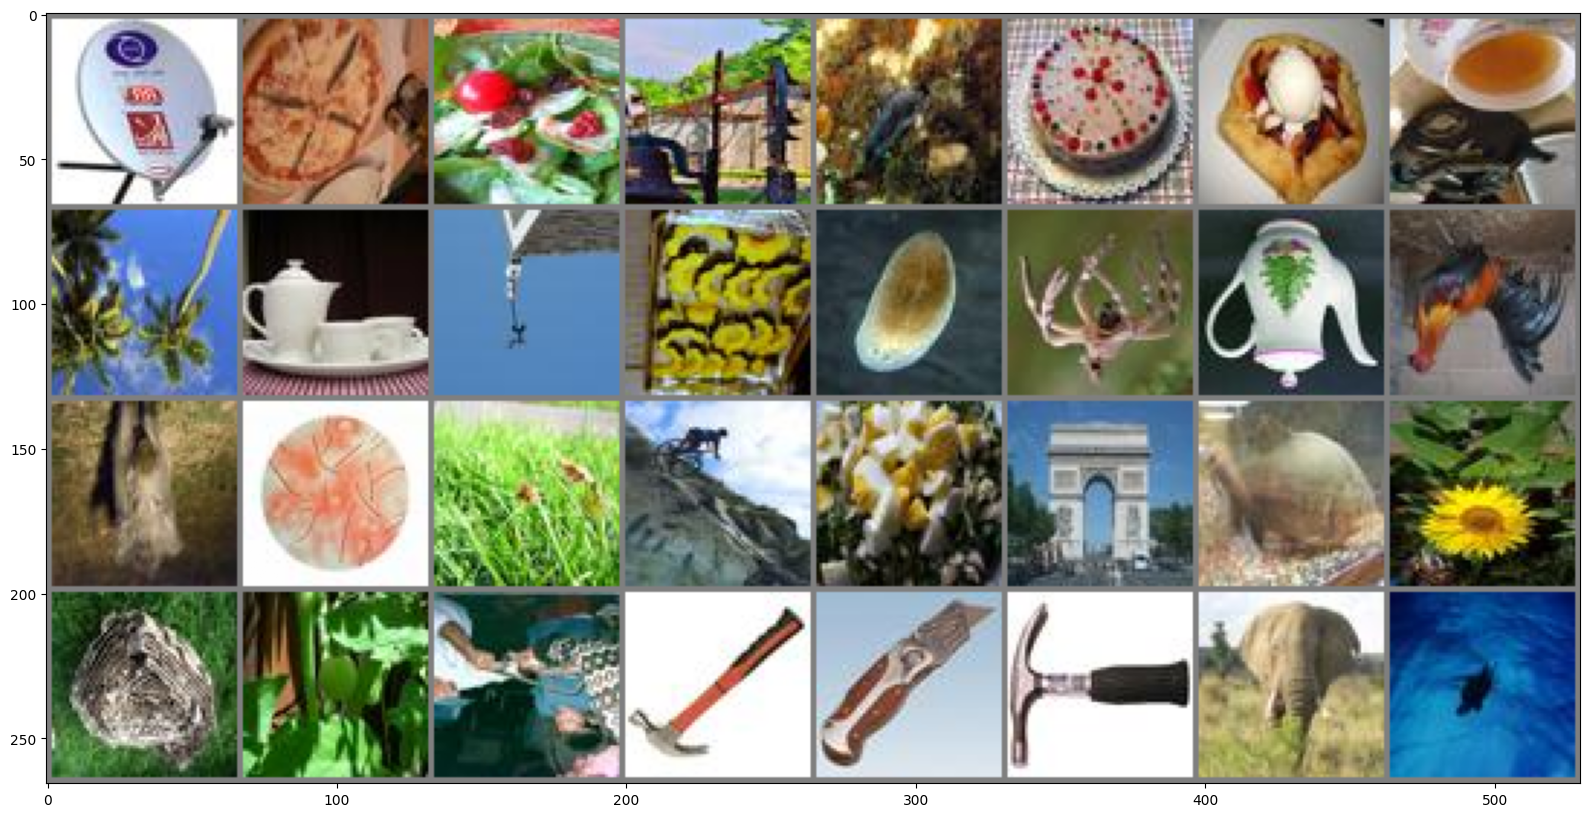

antenna pizza tomato acoustic  worm icecream icecream   tea  palm   pot gauge squash  worm spider   pot  bird swine bacteria beetle bicycle   egg memorial  fish flower  nest tomato   saw hammer   saw hammer elephant turtle


In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=0)
        ## Warstwa max pooling
        self.norm1 = nn.BatchNorm2d(128) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 256, 3)
        self.norm2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Poprawka na max pooling
        self.conv3 = nn.Conv2d(256, 512, 3)
        self.norm3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Poprawka na max pooling
        self.fc1 = nn.Linear(512 * 6 * 6, 128)  # 16 * 13 * 13 zamiast 16 * 5 * 5
        self.norm4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.norm2(self.conv2(x))))       
        x = self.pool3(F.relu(self.norm3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.norm4(self.fc1(x))) #self.norm4
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
# net
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
images, labels = next(iter(train_loader))
images[0:1].size()

torch.Size([1, 3, 64, 64])

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
images, labels = next(iter(train_loader))
images[0:1].size()

torch.Size([1, 3, 64, 64])

In [30]:
losses = []
net.train()
size = len(train_loader)
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    epoch_loss = running_loss / size
    print('[%d/20] loss: %.3f' %
          (epoch+1 ,  epoch_loss))
    losses.append(epoch_loss)

print('Finished Training')

[1/20] loss: 2.789
[2/20] loss: 2.265
[3/20] loss: 2.053
[4/20] loss: 1.903
[5/20] loss: 1.779
[6/20] loss: 1.681
[7/20] loss: 1.580
[8/20] loss: 1.505
[9/20] loss: 1.427
[10/20] loss: 1.355
[11/20] loss: 1.291
[12/20] loss: 1.221
[13/20] loss: 1.164
[14/20] loss: 1.104
[15/20] loss: 1.046
[16/20] loss: 0.991
[17/20] loss: 0.949
[18/20] loss: 0.899
[19/20] loss: 0.851
[20/20] loss: 0.816
Finished Training


In [31]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        loss = criterion(outputs, labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [32]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class acoustic is: 42.3 %
Accuracy for class antenna is: 62.2 %
Accuracy for class bacteria is: 52.7 %
Accuracy for class battery is: 59.7 %
Accuracy for class bean  is: 48.1 %
Accuracy for class beetle is: 71.1 %
Accuracy for class bicycle is: 79.3 %
Accuracy for class birch is: 51.8 %
Accuracy for class bird  is: 37.9 %
Accuracy for class bomb  is: 57.7 %
Accuracy for class bread is: 40.4 %
Accuracy for class bridge is: 68.0 %
Accuracy for class camera is: 64.8 %
Accuracy for class carbon is: 50.5 %
Accuracy for class cat   is: 58.4 %
Accuracy for class corn  is: 52.5 %
Accuracy for class crab  is: 40.3 %
Accuracy for class crocodilian is: 45.8 %
Accuracy for class echinoderm is: 52.2 %
Accuracy for class egg   is: 41.1 %
Accuracy for class elephant is: 64.9 %
Accuracy for class fish  is: 49.6 %
Accuracy for class flower is: 90.3 %
Accuracy for class frog  is: 44.0 %
Accuracy for class fungus is: 61.5 %
Accuracy for class gauge is: 38.6 %
Accuracy for class hammer is: 79

In [33]:

from PIL import Image
import os
import csv


# Lista obrazów w folderze
image_files = os.listdir('test_all')

# Ścieżka do pliku CSV
csv_file = "wyniki.csv"

# Otwieramy plik CSV w trybie zapisu
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Iterujemy po obrazach
    for image_file in image_files:
        # Ładujemy obraz
        image_path = os.path.join('test_all', image_file)
        image = Image.open(image_path).convert('RGB')

        # Stosujemy transformacje
        image = transform(image)

        # Dodajemy wymiar batcha (zgodnie z oczekiwaniami modelu)
        image = image.unsqueeze(0)
        image = image.to(device)

        # Przekazujemy obraz przez sieć
        with torch.no_grad():
            outputs = net(image)

        # Wybieramy klasę o najwyższym prawdopodobieństwie
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()

        # Zapisujemy nazwę pliku i klasę do pliku CSV
        writer.writerow([image_file, class_index])

In [ ]:
# def train(epoch):
#     losses = []
#     size = len(train_loader)
#     for epoch in range(epoch):  # loop over the dataset multiple times

#         running_loss = 0.0
#         for i, data in enumerate(train_loader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
        
#         epoch_loss = running_loss / size
#         # print('[%d/10] loss: %.3f' %
#         #     (epoch+1 ,  epoch_loss))
#         losses.append(epoch_loss)

#     # print('Finished Training')
#     return epoch_loss

# def test():
#     net.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         running_loss = 0.0
#         for data in test_loader:
#             images, labels = data
#             images = images.to(device)
#             # calculate outputs by running images through the network 
#             outputs = net(images).cpu()
#             loss = criterion(outputs, labels)
#             running_loss += loss.item()
#             # the class with the highest energy is what we choose as prediction
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     # print('Accuracy of the network on the 10000 test images: %d %%' % (
#     #     100 * correct / total))
#     return running_loss / len(test_loader)

# train_loss_list = []
# test_loss_list = []
# for i in range(5,50):
#     print(i)
#     train_loss_list.append(train(i))
#     test_loss_list.append(test())

# plt.plot(train_loss_list, label='train')
# plt.plot(test_loss_list, label='test')
# plt.legend()


